In [1]:
import pandas as pd
import numpy as np

import csv
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#primary pre-model pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#backup imports to sub in if pre-model pipeline sucks
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler

#validation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import median_absolute_error, explained_variance_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error

#main model imports and alternates
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb

In [2]:
# Extract text and targets
data = pd.read_csv("MASTERBAITER_DATA.csv")
keys = data.columns.tolist()
print(keys)

['video_id', 'channel_title', 'video_title', 'upload_date', 'view_count']


In [3]:
def normalize_view_count(x):
    min_val = x.min()
    max_val = x.max()
    log_min = np.log1p(min_val)
    log_max = np.log1p(max_val)
    return (np.log1p(x) - log_min) / (log_max - log_min)

# Group by 'channel_title' and apply the custom normalization function
channel_stats = data.groupby('channel_title')['view_count'].transform(normalize_view_count)

# Assign the normalized values to a new column
data['score'] = channel_stats
data['score'] = data['score'].clip(0.0, 1.0)

print(data['score'].isna().any())

False


In [4]:
keys = data.columns.tolist()
print(keys)

['video_id', 'channel_title', 'video_title', 'upload_date', 'view_count', 'score']


False


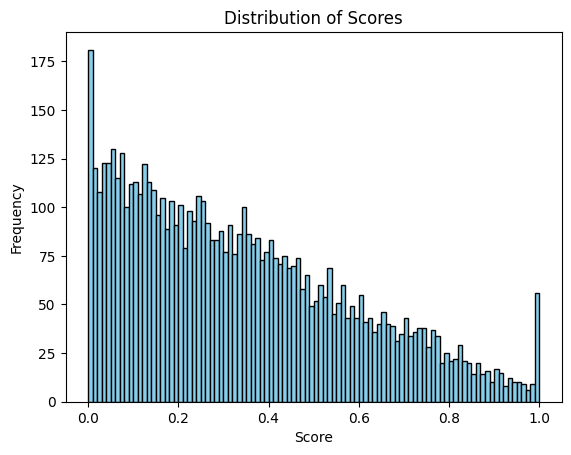

In [5]:
import matplotlib.pyplot as plt

print(data['score'].isna().any())

# Assuming data is your DataFrame containing the scores
plt.hist(data['score'], bins=100, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [162]:
x = data['video_title']
y = data['score']

ogx = data['video_title']
ogy = data['score']

#del data

def remove_outliers(arr, q1pc, q3pc, threshold): # 5 95 1.5
    Q1 = np.percentile(arr, q1pc)
    Q3 = np.percentile(arr, q3pc)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (arr >= lower_bound) & (arr <= upper_bound)

mask = remove_outliers(y, 0, 100, 1.5)

y = np.array(y, dtype=float)[mask]
x = np.array(x)[mask]

mean_y = np.mean(y)
print("Mean:", mean_y)
print("Total", len(y))

min_df_value = 5 #int(len(x) * 0.01)
max_df_value = 0.01
print("Minimum document number:", min_df_value)

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), lowercase = True, stop_words='english', max_features = 10000, min_df=min_df_value, max_df=max_df_value)
#vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 4))
# pickle.save this GPM ngram_vectorizer
# CONSIDER USING WORD ANALYZER INSTEAD AND NGRAM (1,2)
# KEEP LOWERCASE = TRUE (DEFAULT) SO NOT CASE SENSITIVE
# CONSIDER EDITING min_df AND max_df TO GET RID OF OUTLIER TERMS AND CONSIDER ADDING A LIST OF stop_words TO IGNORE
x = vectorizer.fit_transform(x) #fit_transform if fitting and transforming vectorizer from scratch
print("Vectorizer Vocabulary Size:", len(vectorizer.vocabulary_))
# 1.6M with no min_df
# 41283 with min_df = 0.00001 and max_df = 0.1
# 10338 with min_df = 0.0001 and max_df = 0.1
# 1000 with min_df = 0.001 and max = 0.1 (max_features = 1000)

svd = TruncatedSVD(n_components=800, random_state=42)
x = svd.fit_transform(x)
#print("SVD Explanation Ratio:", svd.explained_variance_ratio_)
print("SVD Explanation Ratio:", sum(svd.explained_variance_ratio_)) #target: 0.8

# Add scaler
#scaler = StandardScaler(with_mean=False, copy=False)
# scale x data now
#filtered_scaled_vectorized_x = scaler.fit_transform(filtered_vectorized_x)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
#del x
#del y
print("Train sample size:", len(train_y))
print("Test sample size:", len(test_y))

Mean: 0.33841562750268384
Total 6337
Minimum document number: 5
Vectorizer Vocabulary Size: 1321
SVD Explanation Ratio: 0.8695500139379478
Train sample size: 5069
Test sample size: 1268


In [56]:
print(len(vectorizer.vocabulary_))
print(", ".join([f"{word}" for word, idx in vectorizer.vocabulary_.items()]))

1321
did, fake, update, high, kids, toys, alcohol, explains, cold, ones, getting, tried, drunk, drawing, going, drink, city, free, gifts, strangers, painting, starts, drama, date, films, gets, talks, hot, drinking, brain, damage, happened, night, reveals, face, dolan, dark, tested, iconic, gave, cheap, expensive, spent, products, shocking, tik, tok, gadgets, celebrity, say, coming, ai, ideas, worst, reviewed, games, amazon, phone, got, leaked, battle, 2020, streamers, mr, beast, trying, mistake, attempt, playing, boys, eat, fun, ride, person, surprises, christmas, blind, tasting, cursed, everyday, items, testing, cup, michael, worse, tricked, celebrities, thing, does, science, surprising, old, opening, 30, mystery, break, record, 20, paid, dumb, music, stealing, merch, bought, animations, epic, haul, calling, friend, taste, test, fan, chocolate, box, 1000, guy, turned, insane, tiktok, air, doing, minute, crafts, eating, quot, seen, tv, money, internet, cheapest, wish, weirdest, weird, 

In [57]:
# Select the index of the term you want to access from the vocabulary
index = 0  # Change this index to select a different term (not ordered)

# Get the term at the specified index
term = list(vectorizer.vocabulary_.keys())[index]
#term = 'wow' # use this to select a certain word
 # (error means not in vocabulary) (use only lowercase)

# Get the column index corresponding to the term
term_idx = vectorizer.vocabulary_[term]

# Get the TF-IDF values associated with the term from the TF-IDF matrix
tfidf_values = vectorizer.transform([term]).toarray()

# Calculate the number of documents it appears in
num_documents = (tfidf_values > 0).sum()

# Print the term and its TF-IDF values
print("Term:", term)
print("Index:", term_idx)
print("TF-IDF values:", tfidf_values) # idk what this is exactly.
print("Feature length:", len(tfidf_values[0]))
# this does not tell you how many docs it is in
# tfidf creates a vector to represent each term (if it meets the cutoff)
# and then normalizes it. so this will always equal 1
print("Documents:", num_documents)

Term: did
Index: 344
TF-IDF values: [[0. 0. 0. ... 0. 0. 0.]]
Feature length: 1321
Documents: 1


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0]
}

# Create the LightGBM regressor
model = lgb.LGBMRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=False)

# Fit the grid search to the data
grid_search.fit(train_x, train_y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model
best_model = grid_search.best_estimator_

In [149]:
from sklearn.ensemble import RandomForestRegressor

# Define Random Forest model with specified parameters
model = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    criterion='squared_error',  # Splitting criterion: mean squared error
    max_depth=10,  # Maximum depth of the trees (None means unlimited)
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the sum total of weights
    max_features=1.0,  # Number of features to consider when looking for the best split (1.0 is all)
    max_leaf_nodes=None,  # Maximum number of leaf nodes (None means unlimited)
    min_impurity_decrease=0.0,  # Minimum impurity decrease required for a split
    bootstrap=True,  # Whether bootstrap samples are used when building trees
    oob_score=False,  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
    n_jobs=None,  # Number of jobs to run in parallel for both fit and predict (-1 means using all processors)
    random_state=42,  # Random seed for reproducibility
    verbose=0,  # Verbosity level
    warm_start=False,  # Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
    ccp_alpha=0.0,  # Complexity parameter used for Minimal Cost-Complexity Pruning
    max_samples=None  # Number of samples to draw from X to train each base estimator
)

# Fit the model to the training data
model.fit(train_x, train_y)

RandomForestRegressor(max_depth=10, random_state=42)

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVR
#model = MultinomialNB(alpha=1.0)
model = LinearSVR(
    epsilon=0.0,
    tol=0.0001,
    C=0.1,
    loss='epsilon_insensitive',
    max_iter=10000,
    fit_intercept=True,
    random_state=42
)
model.fit(train_x, train_y)

LinearSVR(C=0.1, max_iter=10000, random_state=42)

In [163]:
from sklearn.linear_model import Ridge
#model = Ridge(alpha=1.0, solver='auto', max_iter=10000, fit_intercept=True, random_state=42)
#model = lgb.LGBMRegressor(
model = xgb.XGBRegressor( # the following hyperparameters were tuned for xgboost
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=5,  # Maximum tree depth
    num_leaves=5,  # Number of leaves in each tree
    min_child_samples=20,  # Minimum number of samples required to create a leaf
    subsample=0.8,  # Subsample ratio of the training instance
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    reg_alpha=0.1,  # L1 regularization term on weights
    reg_lambda=0.1,  # L2 regularization term on weights
    random_state=42
)
model.fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:36:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_child_samples", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_samples=20, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_leaves=5, ...)

In [164]:
# Evaluate model on the filtered test set
preds_test = np.abs(model.predict(test_x))

# Calculate RMSE
rmse = mean_squared_error(test_y, preds_test, squared=False)

# Calculate MAE
mae = mean_absolute_error(test_y, preds_test)

# Calculate R2 score
r2 = r2_score(test_y, preds_test)

# Calculate and display various regression metrics
mse = mean_squared_error(test_y, preds_test)
mae = mean_absolute_error(test_y, preds_test)
medae = median_absolute_error(test_y, preds_test)
explained_var = explained_variance_score(test_y, preds_test)
r2 = r2_score(test_y, preds_test)
mape = mean_absolute_percentage_error(test_y, preds_test)
m2le = mean_squared_log_error(test_y, abs(preds_test))


# Print the additional metrics
print("TEST")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Median Absolute Error (MedAE): {medae:.2f}")
print(f"Explained Variance: {explained_var:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Squared Log Error (M2LE): {m2le:.2f}")

#importances = np.abs(thnkr.coef_ / thnkr.coef_.std())
#print(importances)
#print(thnkr.get_params())

print("")
print("")

# Evaluate model on the filtered train set
preds_train = np.abs(model.predict(train_x))

# Calculate RMSE
rmse = mean_squared_error(train_y, preds_train, squared=False)

# Calculate MAE
mae = mean_absolute_error(train_y, preds_train)

# Calculate R2 score
r2 = r2_score(train_y, preds_train)

# Calculate and display various regression metrics
mse = mean_squared_error(train_y, preds_train)
mae = mean_absolute_error(train_y, preds_train)
medae = median_absolute_error(train_y, preds_train)
explained_var = explained_variance_score(train_y, preds_train)
r2 = r2_score(train_y, preds_train)
mape = mean_absolute_percentage_error(train_y, preds_train)
m2le = mean_squared_log_error(train_y, abs(preds_train))


# Print the additional metrics
print("TRAIN")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Median Absolute Error (MedAE): {medae:.2f}")
print(f"Explained Variance: {explained_var:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Squared Log Error (M2LE): {m2le:.2f}")

#importances = np.abs(thnkr.coef_ / thnkr.coef_.std())
#print(importances)
#print(thnkr.get_params())

TEST
RMSE: 0.24
MAE: 0.20
R2 Score: 0.09
Mean Squared Error (MSE): 0.06
Mean Absolute Error (MAE): 0.20
Median Absolute Error (MedAE): 0.17
Explained Variance: 0.09
R-squared (R2): 0.09
Mean Absolute Percentage Error (MAPE): 6828614453402.59%
Mean Squared Log Error (M2LE): 0.03


TRAIN
RMSE: 0.15
MAE: 0.12
R2 Score: 0.62
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.12
Median Absolute Error (MedAE): 0.10
Explained Variance: 0.62
R-squared (R2): 0.62
Mean Absolute Percentage Error (MAPE): 7694961805610.15%
Mean Squared Log Error (M2LE): 0.01


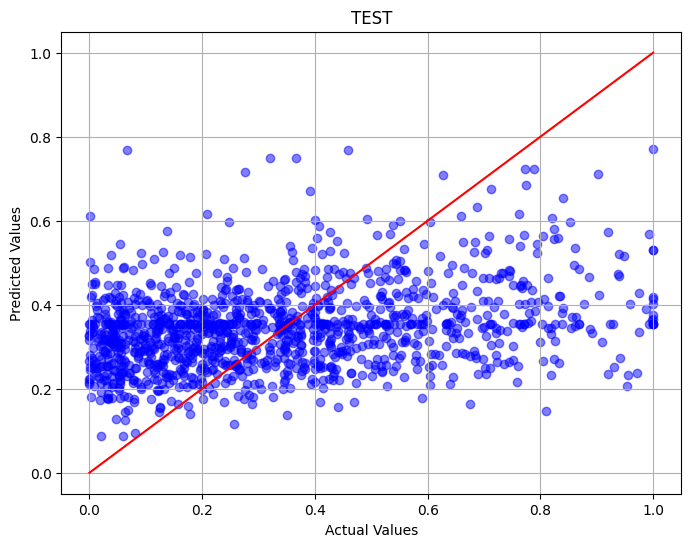

In [165]:
import matplotlib.pyplot as plt

# Assuming 'preds' is your array of predicted values and 'test_y' is your array of actual values
plt.figure(figsize=(8, 6))
plt.scatter(test_y, preds_test, color='blue', alpha=0.5, label='Predicted')  # Predicted values in blue
#plt.scatter(test_y, test_y, color='red', alpha=0.5, label='Actual')  # Actual values in red
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red')  # Diagonal line for reference
plt.title('TEST')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

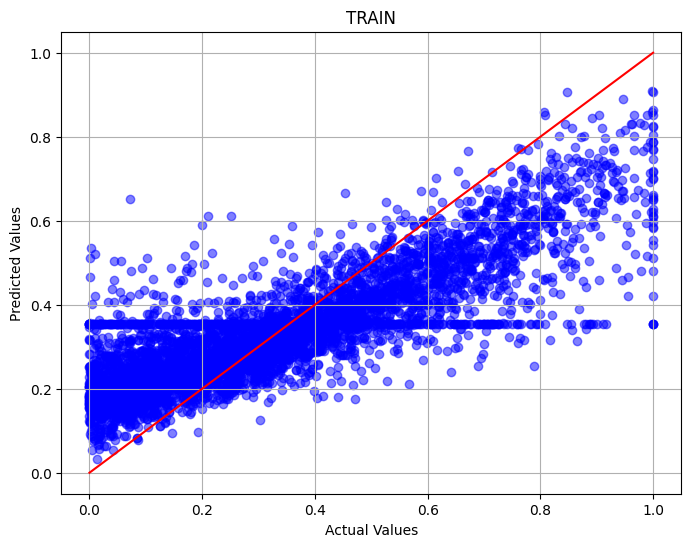

In [166]:
import matplotlib.pyplot as plt

# Assuming 'preds' is your array of predicted values and 'test_y' is your array of actual values
plt.figure(figsize=(8, 6))
plt.scatter(train_y, preds_train, color='blue', alpha=0.5, label='Predicted')  # Predicted values in blue
#plt.scatter(train_y, train_y, color='red', alpha=0.5, label='Actual')  # Actual values in red
plt.plot([min(train_y), max(train_y)], [min(train_y), max(train_y)], color='red')  # Diagonal line for reference
plt.title('TRAIN')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [116]:
# Calculate and print the mean predicted and mean actual prices for filtered data
preds = preds_test
mean_predicted = sum(preds) / len(preds)
mean_true = sum(test_y) / len(test_y)
print(f"Mean Predicted Score (Filtered): {mean_predicted:.2f}")
print(f"Mean Actual Actual (Filtered): {mean_true:.2f}")
print("MSE (Filtered):", mean_squared_error(test_y, preds))

for i in range(50):
    #print(f"Example {i + 1}: \"{x[i]}\"")
    print(f"Example {i + 1} - True Score: {test_y[i]:.2f}, Predicted Score: {preds[i]:.2f}")

Mean Predicted Score (Filtered): 0.34
Mean Actual Actual (Filtered): 0.34
MSE (Filtered): 0.05761794177264261
Example 1 - True Score: 0.05, Predicted Score: 0.24
Example 2 - True Score: 0.12, Predicted Score: 0.20
Example 3 - True Score: 0.27, Predicted Score: 0.34
Example 4 - True Score: 0.13, Predicted Score: 0.44
Example 5 - True Score: 0.34, Predicted Score: 0.38
Example 6 - True Score: 0.37, Predicted Score: 0.36
Example 7 - True Score: 0.04, Predicted Score: 0.31
Example 8 - True Score: 0.44, Predicted Score: 0.25
Example 9 - True Score: 0.15, Predicted Score: 0.31
Example 10 - True Score: 0.25, Predicted Score: 0.35
Example 11 - True Score: 0.57, Predicted Score: 0.44
Example 12 - True Score: 0.64, Predicted Score: 0.39
Example 13 - True Score: 0.34, Predicted Score: 0.35
Example 14 - True Score: 0.31, Predicted Score: 0.26
Example 15 - True Score: 0.04, Predicted Score: 0.52
Example 16 - True Score: 0.45, Predicted Score: 0.39
Example 17 - True Score: 0.11, Predicted Score: 0.3

In [161]:
index = 800

input = ogx[index]
pred_vec = model.predict(svd.transform(vectorizer.transform([input])))
true = ogy[index]

print("Input:", input)
print("Predicted score (vec):", pred_vec[0])
print("Predicted score (vec):", np.log1p(pred_vec[0]))
print("True:", true)

Input: Troye Sivan Played Young Wolverine?!
Predicted score (vec): 0.30217636
Predicted score (vec): 0.26403698
True: 0.111343084025276


In [167]:
masterbaiter_pipeline = Pipeline([
    ('vec', vectorizer),  # Pre-fitted vectorizer
    ('svd', svd),  # Pre-fitted SVD
    ('model', model)  # Pre-fitted model
])

In [189]:
rating = masterbaiter_pipeline.predict([""])[0]
rating = (rating / 2 + 0.5).clip(0.0, 1.0)
print(rating)

0.6510881781578064


In [190]:
joblib.dump(masterbaiter_pipeline, 'masterbaiter_pipeline.joblib')

['masterbaiter_pipeline.joblib']